---
title: "My Notebook Report"
format:
  html:
    embed-resources: true
---

# Построение простых решений для радиального притока

In [1]:
import sympy as sp
import anaflow
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# определим переменные с которыми будем работать 

r = sp.symbols('r', real=True, positive=True)
t = sp.symbols('t', real=True, positive=True)
k, phi, mu, c_t, h = sp.symbols('k phi mu c_t h', real=True, positive=True)
p = sp.symbols('p', cls=sp.Function, real=True, positive=True)

r_d = sp.symbols('r_D', real=True, positive=True)
t_d = sp.symbols('t_D', real=True, positive=True)
p_d = sp.symbols('p_D', cls=sp.Function, real=True, positive=True)

r_w, p_i, q_ref = sp.symbols('r_w p_i q_ref', real=True, positive=True)


r_wd = sp.symbols('r_wd', real=True, positive=True)
q_d = sp.symbols('q_d', real=True, positive=True)
pi = sp.symbols('pi', real=True, positive=True)

u = sp.symbols('u',real=True, positive=True)

a, b = sp.symbols('a b', real=True, positive=True)

pi = sp.pi

# Исходные уравнения

Рассматривается уравнение фильтрации в безразмерных переменных 

$$ 
\frac{\partial p_D}{ \partial t_D} = \frac{1}{r_D}\left[ \frac{ \partial{}}{ \partial{r_D} }\left( r_D \dfrac{\partial p_D}{ \partial r_D} \right) \right]  
\tag{1}
$$

где введены следующие безразмерные переменные
* $r_D$ - безразмерное расстояние от центра скважины
* $t_D$ - безразмерное время
* $p_D$ - безразмерное давление

Соответствующие определения безразмерных переменных

$$ r_D = \frac{r}{r_w} \tag{2}$$
$$ t_D = \frac{0.00036 kt}{\phi \mu c_t r_w^2}  \tag{3}$$
$$ p_D = \frac{kh}{ 18.42 q_{ref} B \mu} \left( p_i - p \right)  \tag{4} $$
$$ q_D = \frac{kh}{18.42 q_{ref} B \mu} q \tag{5}$$

где в свою очередь 
* $q$ - дебит скважины на поверхности, приведенный к нормальным условиям, м^3^/сут
* $q_{ref}$ - референсный дебит скважины на поверхности, приведенный к нормальным условиям, м^3^/сут
* $\phi$ - пористость, доли единиц
* $\mu$ - вязкость нефти в пласте, сП
* $B$ - объемный коэффициент нефти, м^3^/м^3^
* $p_i$ - начальное давление в пласте, атм
* $p$ - давление забойное, атм
* $c_t$ - общая сжимаемость системы в пласте, 1/атм
* $k$ - проницаемость, мД
* $t$ -  время, час
* $r$ - расстояние от центра скважины, м
* $r_w$ - радиус скважины, м

Некоторые рассуждения и преобразования с дебитом

Для радиальной модели можно получить

$$
q = - \left.  2 \pi r \frac{dP}{dr} \right|_{r=r_w}
$$

заменяя переменные в правой части можно получить

$$
q = - \left. 2\pi r_D  \frac{18.42 q_{ref} B \mu }{kh} \frac{d p_D}{d r_D} \right|_{r_D=1}
$$


$$
q = - \left. 2\pi  \frac{18.42 q_{ref} B \mu }{kh}  r_D  \frac{d p_D}{d r_D} \right|_{r_D=1}
$$

$$
q_D = \frac{q}{q_{ref}} = - \left. 2\pi  \frac{18.42 B \mu }{kh}  r_D  \frac{d p_D}{d r_D} \right|_{r_D=1}
$$




$$
q_D = \frac{kh}{18.42 q_{ref} B \mu} q= - \left. 2\pi   r_D  \frac{d p_D}{d r_D} \right|_{r_D=1}
$$


$$
q_D = - \left. 2\pi   r_D  \frac{d p_D}{d r_D} \right|_{r_D=1}
$$

из определения безразмерного давления
$$
\frac{18.42 q_{ref} B \mu}{kh} = \frac{p_i-p}{p_D}
$$

Применив преобразование Лапласа получим выражение

$$u \widetilde{p_D}  =  \dfrac{1}{r_D} \left[\dfrac{d}{d r_D} \left(r_D \dfrac{d{\widetilde{p_D}}}{d r_D} \right) \right]$$

Общее решение
$$\widetilde{p_D}(u, r_D) = A(u) K_0(r_D \sqrt u) + B(u) I_0(r_D \sqrt u) $$


In [3]:
# определим безразмерные переменные

# определим функции для перевода размерных переменных в безразмерные и обратно
# пригодится потом для построения графиков и ведения расчетов

# при наименовании функций придерживаемся следующих соглашений
# сначала идет название того, что считаем
# в конце указывается размерность результата, если это уместно



def q_from_qd_sm3day(qd, k_mD=10, h_m=10, b_m3m3=1.2, mu_cP=1, q_ref=1):
    """
    перевод безразмерного дебита скважины в размерный
    qd - безразмерный дебит скважины
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    b_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    dp_atm - перепад давлений, атм.
    """
    return  (18.42 * q_ref * b_m3m3 * mu_cP) / (k_mD * h_m) * qd

def qd_from_q(q_sm3day, k_mD=10, h_m=10, b_m3m3=1.2, mu_cP=1, q_ref=1):
    """
    перевод размерного дебита в безразмерные
    q_sm3day -  дебит скважины, ст. м3/сут
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    b_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    dp_atm - перепад давлений, атм.
    """
    return k_mD * h_m / (18.42 * q_ref * b_m3m3 * mu_cP)  * q_sm3day

def r_from_rd_m(rd, rw_m=0.1):
    """
    перевод безразмерного расстояния в размерное
    rd -  безразмерное расстояние
    rw_m -  радиус скважины, м
    """
    return rd*rw_m

def rd_from_r(r_m, rw_m=0.1):
    """
    перевод размерного расстояния в безразмерное
    r_m - размерное расстояние, м
    rw_m - радиус скважины, м
    """
    return r_m/rw_m

def t_from_td_hr(td, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод безразмерного времени в размерное, результат в часах
    td - безразмерное время
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return td * phi * mu_cP * ct_1atm * rw_m * rw_m / k_mD / 0.00036

def td_from_t(t_hr, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод размерного времени в безразмерное
    t_hr - размерное время, час
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return  0.00036 * t_hr * k_mD / (phi * mu_cP * ct_1atm * rw_m * rw_m)

def p_from_pd_atma(pd, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод безразмерного давления в размерное, результат в абсолютных атмосферах
    pd - безразмерное давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    fvf_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return pi_atma - pd * 18.42 * q_sm3day * b_m3m3 * mu_cP / k_mD / h_m

def pd_from_p(p_atma, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод размерного давления в безразмерное
    p_atma - давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    fvf_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return (pi_atma - p_atma) / (18.42 * q_sm3day * b_m3m3 * mu_cP) * k_mD * h_m


# Вернемся к готовым решениям

In [4]:
# определим уравнение фильтрации в пространстве Лапласа
diff_eq = sp.Eq(u * p_d(r_d),
                1 / r_d * (sp.diff(r_d * sp.diff(p_d(r_d), r_d) , r_d)) )
diff_eq

Eq(u*p_D(r_D), (r_D*Derivative(p_D(r_D), (r_D, 2)) + Derivative(p_D(r_D), r_D))/r_D)

In [5]:
# попробуем решить уравнение 
soln = sp.dsolve(diff_eq, p_d(r_d))
soln

Eq(p_D(r_D), C1*besseli(0, r_D*sqrt(u)) + C2*bessely(0, I*r_D*sqrt(u)))

In [6]:
# зададим в явном виде решение с использованием K_0 и I_0
A, B = sp.symbols('A B')
soln2 = sp.Eq(p_d(r_d) , A * sp.besselk(0, r_d * sp.sqrt(u)) + B * sp.besseli(0, r_d * sp.sqrt(u)))
soln2

Eq(p_D(r_D), A*besselk(0, r_D*sqrt(u)) + B*besseli(0, r_D*sqrt(u)))

##  Частное решение для бесконечного пласта и конечного радиуса скважины и постоянного дебита. <a class="anchor" id="423"></a>

Частное решение строится за счет поиска параметров $A$ и $B$ для уравнения (2.5) так, чтобы они удовлетворяли граничным условиям. 

1. Граничное условия на бесконечности 

$$\lim_{r_D \to \infty} p_D(r_D, t_D) = 0  \tag{3.1}$$

в пространстве Лапласа  \eqref{3.1} преобразуется в следующее

$$\lim_{r_D \to \infty} \tilde{p}_D(r_D, u) = 0 \tag{3.2}$$

2. Граничное условие на скважине - единичный дебит в безразмерных переменных

$$\lim_{r_D \to r_{wD}} \left[ 2\pi r_D \dfrac{ \partial p_D(r_D, t_D)}{\partial r_D} \right] = -1  \tag{3.3}$$

в пространстве Лапласа  (3.3) с учетом выражения (12.9) преобразуется к

$$
\lim_{r_D \to r_{wD}} \left[ r_D \dfrac{ d \tilde{p}_D}{d r_D} \right] = -\dfrac{2 \pi}{u} \tag{3.4}
$$ 


In [7]:
sp.limit(soln2.rhs, r_d, sp.oo)

oo*sign(B)

Для того, чтобы удовлетворить условию на бесконечности необходимо положить $B=0$

In [8]:
soln3 = soln2.subs(B, 0)
print('Общее решение с учетом условия на бесконечности')
display(soln3)

Общее решение с учетом условия на бесконечности


Eq(p_D(r_D), A*besselk(0, r_D*sqrt(u)))

In [9]:

print('граничное условие на скважине')
bc_well = sp.Eq( 2* pi *r_d * sp.diff(p_d(t_d, r_d), r_d) ,-1)
display(bc_well)
print('применим преобразование Лапласа к обеим частям граничного условия')
eq_boundary_Laplace = sp.Eq(sp.laplace_transform(bc_well.lhs, t_d, u,  noconds=True) ,  
                            sp.laplace_transform(bc_well.rhs, t_d, u,  noconds=True))
display(eq_boundary_Laplace)
print('Выражение для граничного условия на скважине')
bc2 = sp.Eq( 2* pi *r_d * soln3.rhs.diff(r_d), eq_boundary_Laplace.rhs)
display(bc2)
print('найдем A')
bc2_sol = sp.solve(bc2.subs(r_d, r_wd), A)
display(sp.Eq(A,bc2_sol[0]))
print('частное решение для любого расстояния и условия на забое r_wd=1')
soln4 = soln3.subs(A, bc2_sol[0]).subs(r_wd, 1)
display(soln4)
print('частное решение для забойного давления')
soln5 = soln4.subs(r_wd, 1).subs(r_d, 1)
display(soln5)

граничное условие на скважине


Eq(2*pi*r_D*Derivative(p_D(t_D, r_D), r_D), -1)

применим преобразование Лапласа к обеим частям граничного условия


Eq(2*pi*r_D*LaplaceTransform(Derivative(p_D(t_D, r_D), r_D), t_D, u), -1/u)

Выражение для граничного условия на скважине


Eq(-2*pi*A*r_D*sqrt(u)*besselk(1, r_D*sqrt(u)), -1/u)

найдем A


Eq(A, 1/(2*pi*r_wd*u**(3/2)*besselk(1, r_wd*sqrt(u))))

частное решение для любого расстояния и условия на забое r_wd=1


Eq(p_D(r_D), besselk(0, r_D*sqrt(u))/(2*pi*u**(3/2)*besselk(1, sqrt(u))))

частное решение для забойного давления


Eq(p_D(1), besselk(0, sqrt(u))/(2*pi*u**(3/2)*besselk(1, sqrt(u))))

0.11132632596312182


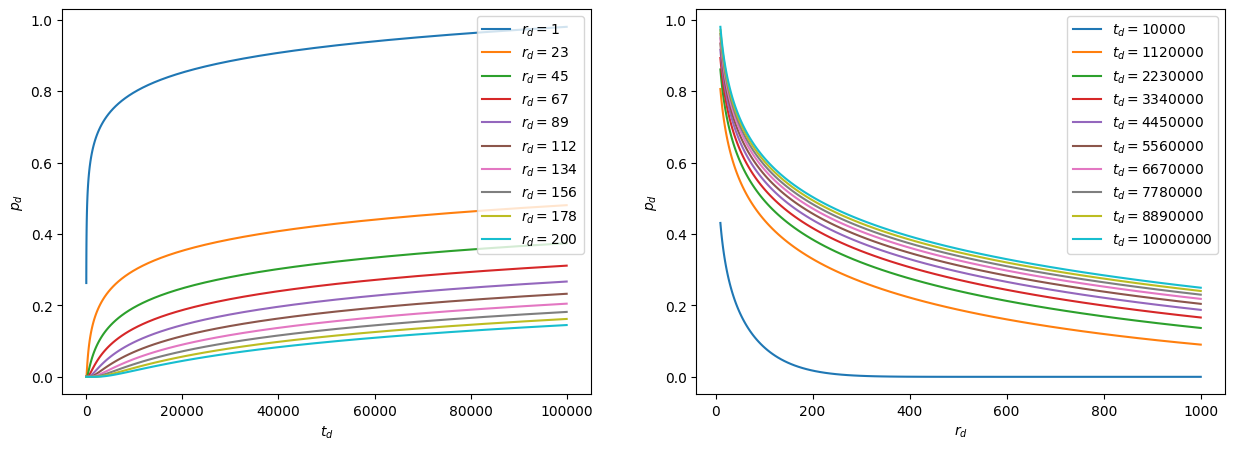

In [10]:
# преобразование sympy выражения в lambda функцию с использованием numpy
soln4_numpy = sp.lambdify([u, r_d], soln4.rhs, modules = ['numpy', 'scipy'])

# после преобразования lambda функцию можно использовать для проведения расчетов как обычныую функцию
# пример расчета для одного значения, чтобы убедиться, что все работает
print(soln4_numpy(u=1, r_D=1))

# определим функцию для расчета обратного преобразования Лапласа
# отдельная функция удобно чтобы передавать r_d второй параметр
def soln4_inv_lapl_numpy(t_d=1000, r_d=1):
    sol_lap = anaflow.get_lap_inv(soln4_numpy,  r_D=r_d)
    return sol_lap(t_d)

# зададим диапазоны изменения параметров для построения графиков
td_arr = np.logspace(1,5,100)
rd_arr = np.logspace(1,3,100)

# построим графики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,5])
for ri in np.linspace(1,200,10):
    ax1.plot(td_arr, soln4_inv_lapl_numpy(td_arr, r_d=ri), label = f'$r_d={ri:.0f}$')
for ti in np.linspace(1e4, 1e7,10):
    ax2.plot(rd_arr, np.squeeze( [soln4_inv_lapl_numpy(ti, r_d=ri) for ri in rd_arr ] ), label = f'$t_d={ti:.0f}$')
# наведем немного красоты
ax1.set_xlabel('$t_d$')
ax1.set_ylabel('$p_d$')
ax1.legend()
ax2.set_xlabel('$r_d$')
ax2.set_ylabel('$p_d$')
ax2.legend()
plt.show()

##  Частное решение для бесконечного пласта, конечного радиуса скважины и линейно меняющегося дебита. 

Частное решение строится за счет поиска параметров $A$ и $B$ для уравнения (2.5) так, чтобы они удовлетворяли граничным условиям. 

1. Граничное условия на бесконечности 

$$\lim_{r_D \to \infty} p_D(r_D, t_D) = 0  \tag{3.1}$$

в пространстве Лапласа  \eqref{3.1} преобразуется в следующее

$$\lim_{r_D \to \infty} \tilde{p}_D(r_D, u) = 0 \tag{3.2}$$

2. Граничное условие на скважине - единичный дебит в безразмерных переменных

$$\lim_{r_D \to r_{wD}} \left[ 2\pi r_D \dfrac{ \partial p_D(r_D, t_D)}{\partial r_D} \right] = - at_D +b  \tag{3.3}$$

в пространстве Лапласа  (3.3) с учетом выражения (12.9) преобразуется к

$$
\lim_{r_D \to r_{wD}} \left[ r_D \dfrac{ d \tilde{p}_D}{d r_D} \right] = -\dfrac{2 \pi}{u} \tag{3.4}
$$ 


Запишем решение для линейного меняющегося дебита на скважине

In [11]:

print('граничное условие на скважине')
bc_well = sp.Eq( 2* pi *r_d * sp.diff(p_d(t_d, r_d), r_d) ,-a * t_d + b)
display(bc_well)
print('применим преобразование Лапласа к обеим частям граничного условия')
eq_boundary_Laplace = sp.Eq(sp.laplace_transform(bc_well.lhs, t_d, u,  noconds=True) ,  
                            sp.laplace_transform(bc_well.rhs, t_d, u,  noconds=True))
display(eq_boundary_Laplace)
print('Выражение для граничного условия на скважине')
bc2 = sp.Eq( 2* pi *r_d * soln3.rhs.diff(r_d), eq_boundary_Laplace.rhs)
display(bc2)
print('найдем A')
bc2_sol = sp.solve(bc2.subs(r_d, r_wd), A)
display(sp.Eq(A,bc2_sol[0]))
print('частное решение для любого расстояния и условия на забое r_wd=1')
soln4 = soln3.subs(A, bc2_sol[0]).subs(r_wd, 1)
display(soln4)
print('частное решение для забойного давления')
soln5 = soln4.subs(r_wd, 1).subs(r_d, 1)
display(soln5)

граничное условие на скважине


Eq(2*pi*r_D*Derivative(p_D(t_D, r_D), r_D), -a*t_D + b)

применим преобразование Лапласа к обеим частям граничного условия


Eq(2*pi*r_D*LaplaceTransform(Derivative(p_D(t_D, r_D), r_D), t_D, u), -a/u**2 + b/u)

Выражение для граничного условия на скважине


Eq(-2*pi*A*r_D*sqrt(u)*besselk(1, r_D*sqrt(u)), -a/u**2 + b/u)

найдем A


Eq(A, (a - b*u)/(2*pi*r_wd*u**(5/2)*besselk(1, r_wd*sqrt(u))))

частное решение для любого расстояния и условия на забое r_wd=1


Eq(p_D(r_D), (a - b*u)*besselk(0, r_D*sqrt(u))/(2*pi*u**(5/2)*besselk(1, sqrt(u))))

частное решение для забойного давления


Eq(p_D(1), (a - b*u)*besselk(0, sqrt(u))/(2*pi*u**(5/2)*besselk(1, sqrt(u))))

0.11132632596312182


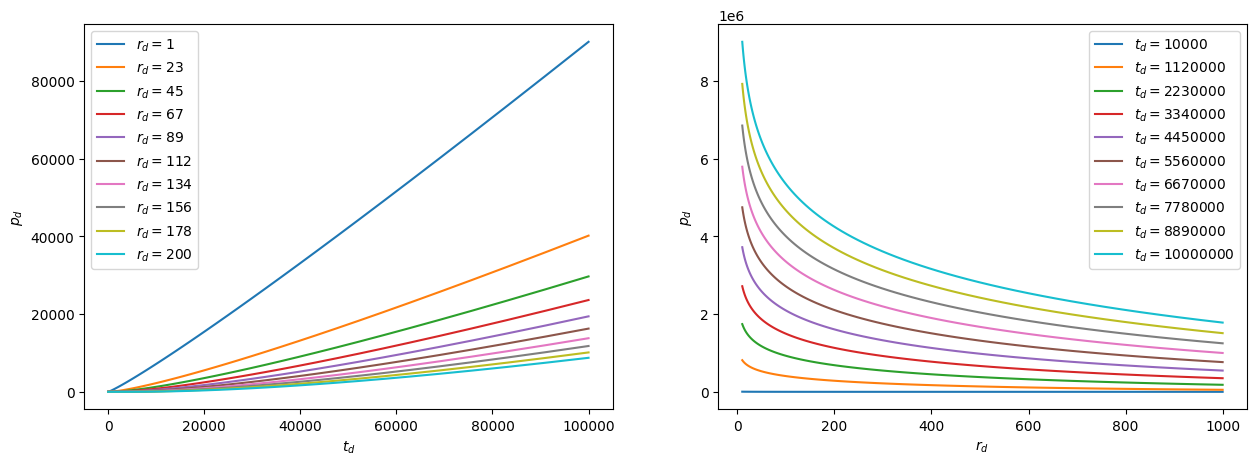

In [12]:
# преобразование sympy выражения в lambda функцию с использованием numpy
soln4_numpy = sp.lambdify([u, r_d], soln4.rhs.subs(a,1).subs(b,0), modules = ['numpy', 'scipy'])

# после преобразования lambda функцию можно использовать для проведения расчетов как обычныую функцию
# пример расчета для одного значения, чтобы убедиться, что все работает
print(soln4_numpy(u=1, r_D=1))

# определим функцию для расчета обратного преобразования Лапласа
# отдельная функция удобно чтобы передавать r_d второй параметр
def soln4_inv_lapl_numpy(t_d=1000, r_d=1):
    sol_lap = anaflow.get_lap_inv(soln4_numpy,  r_D=r_d)
    return sol_lap(t_d)

# зададим диапазоны изменения параметров для построения графиков
td_arr = np.logspace(1,5,100)
rd_arr = np.logspace(1,3,100)

# построим графики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,5])
for ri in np.linspace(1,200,10):
    ax1.plot(td_arr, soln4_inv_lapl_numpy(td_arr, r_d=ri), label = f'$r_d={ri:.0f}$')
for ti in np.linspace(1e4, 1e7,10):
    ax2.plot(rd_arr, np.squeeze( [soln4_inv_lapl_numpy(ti, r_d=ri) for ri in rd_arr ] ), label = f'$t_d={ti:.0f}$')
# наведем немного красоты
ax1.set_xlabel('$t_d$')
ax1.set_ylabel('$p_d$')
ax1.legend()
ax2.set_xlabel('$r_d$')
ax2.set_ylabel('$p_d$')
ax2.legend()
plt.show()

##  Частное решение для бесконечного пласта, конечного радиуса скважины и постоянного забойного давления. 

Частное решение строится за счет поиска параметров $A$ и $B$ для уравнения (2.5) так, чтобы они удовлетворяли граничным условиям. 

1. Граничное условия на бесконечности 

$$\lim_{r_D \to \infty} p_D(r_D, t_D) = 0  \tag{3.1}$$

в пространстве Лапласа  \eqref{3.1} преобразуется в следующее

$$\lim_{r_D \to \infty} \tilde{p}_D(r_D, u) = 0 \tag{3.2}$$

2. Граничное условие на скважине - единичный дебит в безразмерных переменных

$$\lim_{r_D \to r_{wD}} \left[ p_D(r_D, t_D) \right] = 1  \tag{3.3}$$

в пространстве Лапласа  (3.3) с учетом выражения (12.9) преобразуется к

$$\lim_{r_D \to 1} \left[  \widetilde{p_D}(r_D,u) \right] = \dfrac{1}{u} $$


In [13]:

print('граничное условие на скважине')
bc_well = sp.Eq( p_d(t_d, r_d) , 1)
display(bc_well)
print('применим преобразование Лапласа к обеим частям граничного условия')
eq_boundary_Laplace = sp.Eq(sp.laplace_transform(bc_well.lhs, t_d, u,  noconds=True) ,  
                            sp.laplace_transform(bc_well.rhs, t_d, u,  noconds=True))
display(eq_boundary_Laplace)
print('Выражение для граничного условия на скважине')
bc2 = sp.Eq( soln3.rhs, eq_boundary_Laplace.rhs)
display(bc2)
print('найдем A')
bc2_sol = sp.solve(bc2.subs(r_d, r_wd), A)
display(sp.Eq(A,bc2_sol[0]))
print('частное решение для любого расстояния и условия на забое r_wd=1')
soln4 = soln3.subs(A, bc2_sol[0]).subs(r_wd, 1)
display(soln4)
print('частное решение для забойного давления')
soln5 = soln4.subs(r_wd, 1).subs(r_d, 1)
display(soln5)

print('выражение для дебита')
sol_qd = sp.Eq(q_d, (-2 * pi * r_d * sp.diff( soln4.rhs, r_d)).subs(r_d,1))
display(sol_qd)

граничное условие на скважине


Eq(p_D(t_D, r_D), 1)

применим преобразование Лапласа к обеим частям граничного условия


Eq(LaplaceTransform(p_D(t_D, r_D), t_D, u), 1/u)

Выражение для граничного условия на скважине


Eq(A*besselk(0, r_D*sqrt(u)), 1/u)

найдем A


Eq(A, 1/(u*besselk(0, r_wd*sqrt(u))))

частное решение для любого расстояния и условия на забое r_wd=1


Eq(p_D(r_D), besselk(0, r_D*sqrt(u))/(u*besselk(0, sqrt(u))))

частное решение для забойного давления


Eq(p_D(1), 1/u)

выражение для дебита


Eq(q_d, 2*pi*besselk(1, sqrt(u))/(sqrt(u)*besselk(0, sqrt(u))))

1.0


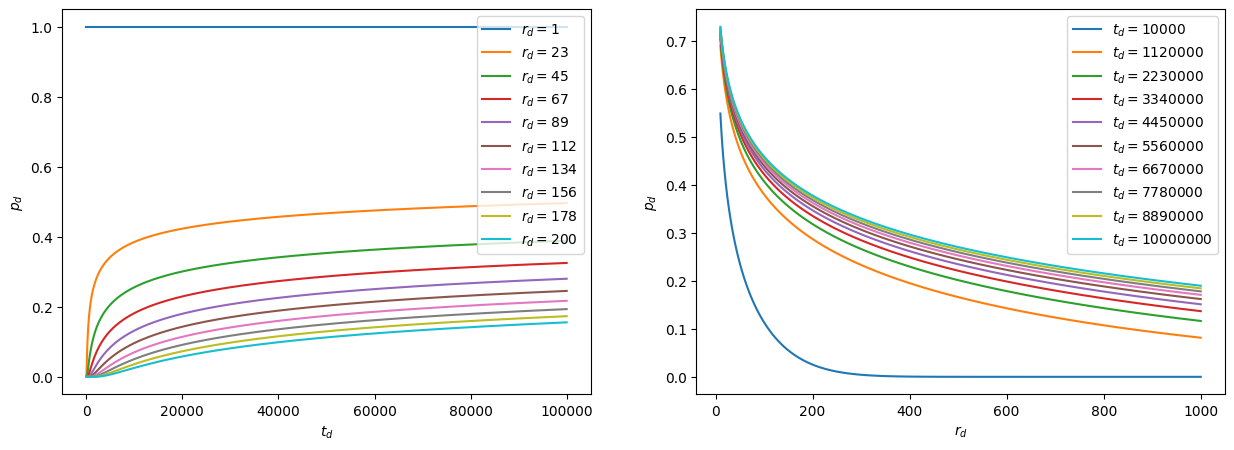

In [14]:
# преобразование sympy выражения в lambda функцию с использованием numpy
soln4_numpy = sp.lambdify([u, r_d], soln4.rhs, modules = ['numpy', 'scipy'])

# после преобразования lambda функцию можно использовать для проведения расчетов как обычныую функцию
# пример расчета для одного значения, чтобы убедиться, что все работает
print(soln4_numpy(u=1, r_D=1))

# определим функцию для расчета обратного преобразования Лапласа
# отдельная функция удобно чтобы передавать r_d второй параметр
def soln4_inv_lapl_numpy(t_d=1000, r_d=1):
    sol_lap = anaflow.get_lap_inv(soln4_numpy,  r_D=r_d)
    return sol_lap(t_d)

# зададим диапазоны изменения параметров для построения графиков
td_arr = np.logspace(1,5,100)
rd_arr = np.logspace(1,3,100)

# построим графики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,5])
for ri in np.linspace(1,200,10):
    ax1.plot(td_arr, soln4_inv_lapl_numpy(td_arr, r_d=ri), label = f'$r_d={ri:.0f}$')
for ti in np.linspace(1e4, 1e7,10):
    ax2.plot(rd_arr, np.squeeze( [soln4_inv_lapl_numpy(ti, r_d=ri) for ri in rd_arr ] ), label = f'$t_d={ti:.0f}$')
# наведем немного красоты
ax1.set_xlabel('$t_d$')
ax1.set_ylabel('$p_d$')
ax1.legend()
ax2.set_xlabel('$r_d$')
ax2.set_ylabel('$p_d$')
ax2.legend()
plt.show()

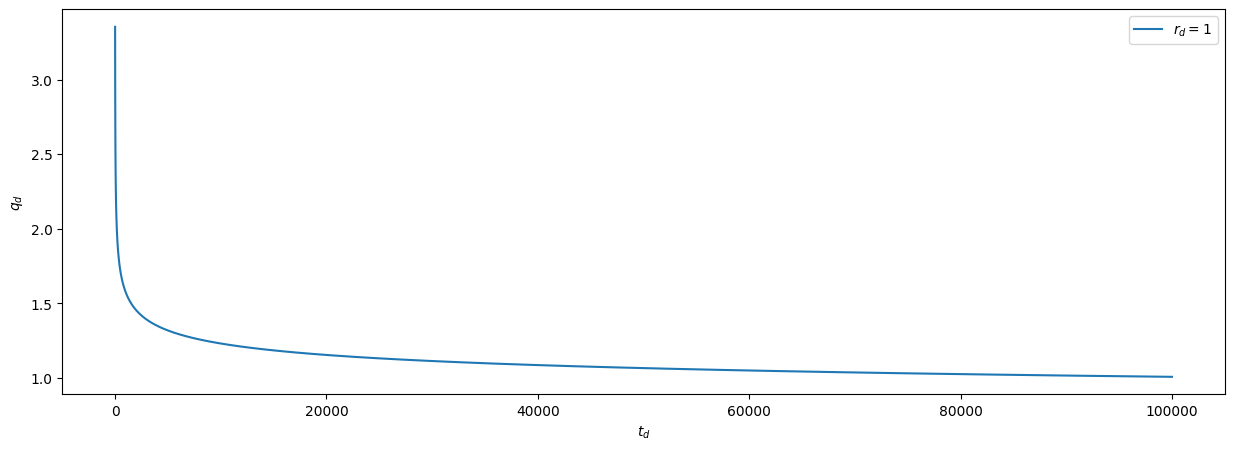

In [15]:
# преобразование sympy выражения в lambda функцию с использованием numpy
soln_qd_numpy = sp.lambdify([u], sol_qd.rhs, modules = ['numpy', 'scipy'])


# определим функцию для расчета обратного преобразования Лапласа
# отдельная функция удобно чтобы передавать r_d второй параметр
def soln_qd_inv_lapl_numpy(t_d=1000):
    sol_lap = anaflow.get_lap_inv(soln_qd_numpy)
    return sol_lap(t_d)

# зададим диапазоны изменения параметров для построения графиков
td_arr = np.logspace(1,5,100)

# построим графики
fig, ax1 = plt.subplots(1, 1, figsize=[15,5])

ax1.plot(td_arr, soln_qd_inv_lapl_numpy(td_arr), label = f'$r_d=1$')

# наведем немного красоты
ax1.set_xlabel('$t_d$')
ax1.set_ylabel('$q_d$')
ax1.legend()
plt.show()

##  Частное решение для бесконечного пласта, конечного радиуса скважины и линейно меняющегося забойного давления. 

Частное решение строится за счет поиска параметров $A$ и $B$ для уравнения (2.5) так, чтобы они удовлетворяли граничным условиям. 

1. Граничное условия на бесконечности 

$$\lim_{r_D \to \infty} p_D(r_D, t_D) = 0  \tag{3.1}$$

в пространстве Лапласа  \eqref{3.1} преобразуется в следующее

$$\lim_{r_D \to \infty} \tilde{p}_D(r_D, u) = 0 \tag{3.2}$$

2. Граничное условие на скважине - единичный дебит в безразмерных переменных

$$\lim_{r_D \to r_{wD}} \left[ p_D(r_D, t_D) \right] = a t_D +b  \tag{3.3}$$

в пространстве Лапласа  (3.3) с учетом выражения (12.9) преобразуется к

$$\lim_{r_D \to 1} \left[  \widetilde{p_D}(r_D,u) \right] = \dfrac{a}{u^2} + \dfrac{b}{u} $$


In [16]:

print('граничное условие на скважине')
bc_well = sp.Eq( p_d(t_d, r_d) , a*t_d+b)
display(bc_well)
print('применим преобразование Лапласа к обеим частям граничного условия')
eq_boundary_Laplace = sp.Eq(sp.laplace_transform(bc_well.lhs, t_d, u,  noconds=True) ,  
                            sp.laplace_transform(bc_well.rhs, t_d, u,  noconds=True))
display(eq_boundary_Laplace)
print('Выражение для граничного условия на скважине')
bc2 = sp.Eq( soln3.rhs, eq_boundary_Laplace.rhs)
display(bc2)
print('найдем A')
bc2_sol = sp.solve(bc2.subs(r_d, r_wd), A)
display(sp.Eq(A,bc2_sol[0]))
print('частное решение для любого расстояния и условия на забое r_wd=1')
soln4 = soln3.subs(A, bc2_sol[0]).subs(r_wd, 1)
display(soln4)
print('частное решение для забойного давления')
soln5 = soln4.subs(r_wd, 1).subs(r_d, 1)
display(soln5)

print('выражение для дебита')
sol_qd = sp.Eq(q_d, (-2 * pi * r_d * sp.diff( soln4.rhs, r_d)).subs(r_d,1))
display(sol_qd)

граничное условие на скважине


Eq(p_D(t_D, r_D), a*t_D + b)

применим преобразование Лапласа к обеим частям граничного условия


Eq(LaplaceTransform(p_D(t_D, r_D), t_D, u), a/u**2 + b/u)

Выражение для граничного условия на скважине


Eq(A*besselk(0, r_D*sqrt(u)), a/u**2 + b/u)

найдем A


Eq(A, (a + b*u)/(u**2*besselk(0, r_wd*sqrt(u))))

частное решение для любого расстояния и условия на забое r_wd=1


Eq(p_D(r_D), (a + b*u)*besselk(0, r_D*sqrt(u))/(u**2*besselk(0, sqrt(u))))

частное решение для забойного давления


Eq(p_D(1), (a + b*u)/u**2)

выражение для дебита


Eq(q_d, 2*pi*(a + b*u)*besselk(1, sqrt(u))/(u**(3/2)*besselk(0, sqrt(u))))

9.999999999999999e-06


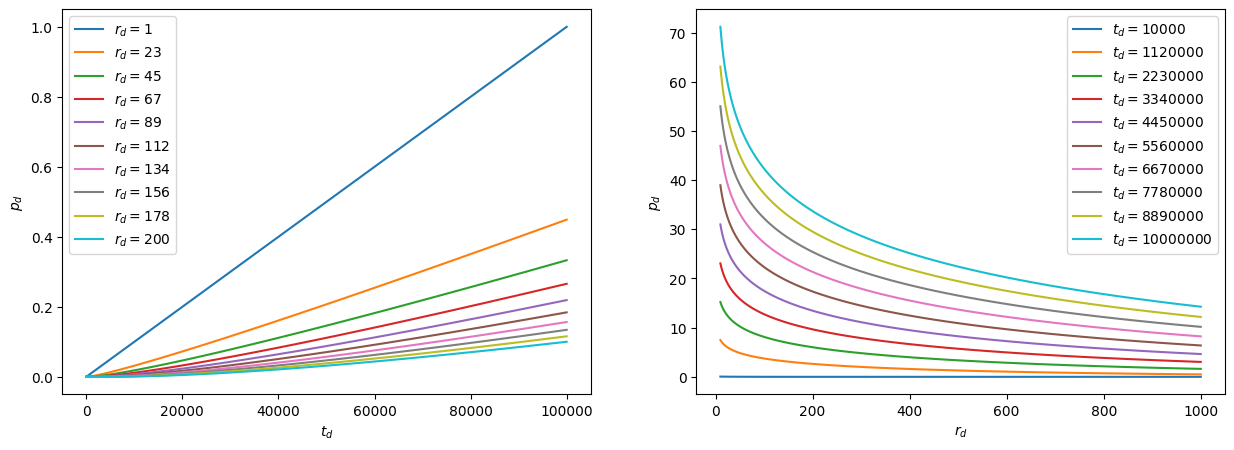

In [17]:
# преобразование sympy выражения в lambda функцию с использованием numpy
soln4_numpy = sp.lambdify([u, r_d], soln4.rhs.subs(a,0.00001).subs(b,0), modules = ['numpy', 'scipy'])

# после преобразования lambda функцию можно использовать для проведения расчетов как обычныую функцию
# пример расчета для одного значения, чтобы убедиться, что все работает
print(soln4_numpy(u=1, r_D=1))

# определим функцию для расчета обратного преобразования Лапласа
# отдельная функция удобно чтобы передавать r_d второй параметр
def soln4_inv_lapl_numpy(t_d=1000, r_d=1):
    sol_lap = anaflow.get_lap_inv(soln4_numpy,  r_D=r_d)
    return sol_lap(t_d)

# зададим диапазоны изменения параметров для построения графиков
td_arr = np.logspace(1,5,100)
rd_arr = np.logspace(1,3,100)

# построим графики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,5])
for ri in np.linspace(1,200,10):
    ax1.plot(td_arr, soln4_inv_lapl_numpy(td_arr, r_d=ri), label = f'$r_d={ri:.0f}$')
for ti in np.linspace(1e4, 1e7,10):
    ax2.plot(rd_arr, np.squeeze( [soln4_inv_lapl_numpy(ti, r_d=ri) for ri in rd_arr ] ), label = f'$t_d={ti:.0f}$')
# наведем немного красоты
ax1.set_xlabel('$t_d$')
ax1.set_ylabel('$p_d$')
ax1.legend()
ax2.set_xlabel('$r_d$')
ax2.set_ylabel('$p_d$')
ax2.legend()
plt.show()

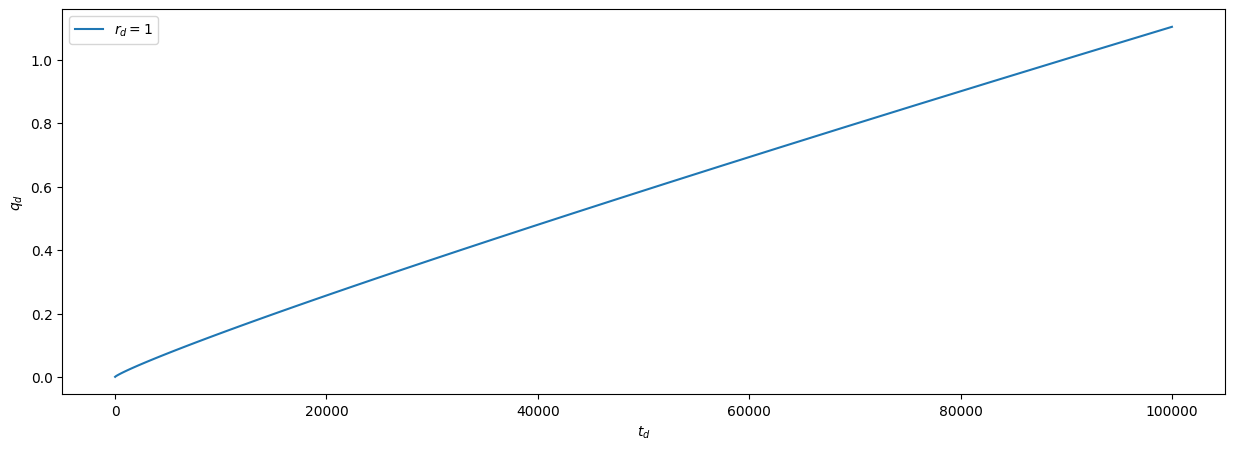

In [18]:
# преобразование sympy выражения в lambda функцию с использованием numpy
soln_qd_numpy = sp.lambdify([u], sol_qd.rhs.subs(a,0.00001).subs(b,0), modules = ['numpy', 'scipy'])


# определим функцию для расчета обратного преобразования Лапласа
# отдельная функция удобно чтобы передавать r_d второй параметр
def soln_qd_inv_lapl_numpy(t_d=1000):
    sol_lap = anaflow.get_lap_inv(soln_qd_numpy)
    return sol_lap(t_d)

# зададим диапазоны изменения параметров для построения графиков
td_arr = np.logspace(1,5,100)

# построим графики
fig, ax1 = plt.subplots(1, 1, figsize=[15,5])

ax1.plot(td_arr, soln_qd_inv_lapl_numpy(td_arr), label = f'$r_d=1$')

# наведем немного красоты
ax1.set_xlabel('$t_d$')
ax1.set_ylabel('$q_d$')
ax1.legend()
plt.show()